# The Inference Button: Bayesian GLMs made easy with PyMC3

Following this blogpost http://twiecki.github.io/blog/2013/09/12/bayesian-glms-1/

Linear regression $Y = X \beta + \epsilon$ reformulated probabilistically is $Y \sim \mathcal{N}(X\beta, \sigma^2)$. Least squares or maximum likelihood is used to find a best fitting $\beta$ in the former. In the latter, bayesian version with probability distribution, $Y$ is viewed as a random variable, of which each element is distributed according to a normal distribution, with mean provided by our linear predictor and variance $\sigma^2$.

In [8]:
import pymc3
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Make some data

In [10]:
size = 200
true_intercept = 1
true_slope = 1

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)

Plot the above

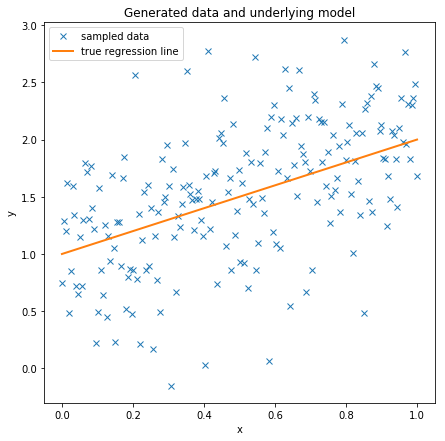

In [11]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title="Generated data and underlying model")
ax.plot(x, y, 'x', label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.)
plt.legend(loc=0)

Model estimation with PyMC3, wrapped with `with` statement.

In [12]:
with pymc3.Model() as model:
    sigma = pymc3.Uniform('sigma', 0, 20)
    intercept = pymc3.Normal('Intercept', 0, sd=20)
    x_coeff = pymc3.Normal('x', 0, sd=20)
    
    # Define likelihood
    likelihood = pymc3.Normal('y', mu=intercept + x_coeff * x, sd=sigma, observed=y)
    
    # Inference:
    start = pymc3.find_MAP() # find starting value for optimization
    step = pymc3.NUTS(state=start) # instantiate MCMC sampling algorithms
    trace = pymc3.sample(2000, step, start=start)

Optimization terminated successfully.
         Current function value: 164.562042
         Iterations: 11
         Function evaluations: 22
         Gradient evaluations: 22


100%|██████████| 2000/2000 [00:11<00:00, 180.74it/s]


Ok so instead of the above, let's use the `glm` module the blog author has created I think.

In [16]:
with pymc3.Model() as model:
    # specify glm and pass in data. The resulting
    # linear model, its likelihood and all its parameters
    # are automatically added to our model
    pymc3.glm.glm('y ~ x', data) # Patsy string, I think
    step = pymc3.NUTS()
    trace = pymc3.sample(2000, step) # draw 2000 posterior samples using NUTS sampling

100%|██████████| 2000/2000 [00:08<00:00, 244.04it/s]


Bayesing inference does not give us only one best fitting line as maximum likelihood does, but rather a whole posterior distribution of likely parameters.

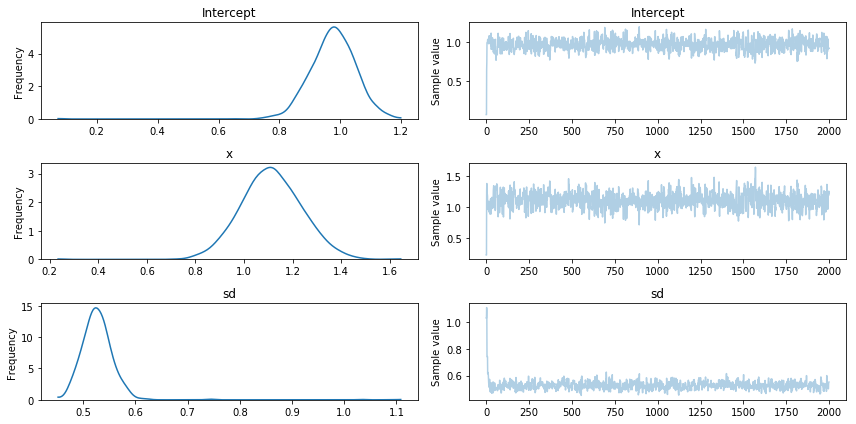

In [20]:
plt.figure(figsize=(7, 7))
pymc3.traceplot(trace)
plt.tight_layout();

Left side is marginal posterior – for each paramater our value on the x-axis we get a probability on the y-axis that tells us how likely that paramater value is.

We maintain uncertainty, since our data is incomplete.